# Questioning the Effect of Physiological Heartbeat Synchrony in Romantic Dyads. A Preregistered Deep Learning Analysis.

### For Google Colab only:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Deep Learning

In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

from lists import list_str, datafiles, datafiles_1k, datafiles_google

tf.version.VERSION

'2.3.0'

In [3]:
# Load data
data = [None]*len(list_str)
for i in range(len(list_str)):
    data[i] = np.load(datafiles[i])
    #data_raw[i] = np.load(datafiles_google[i])

# Data preperation for keras
data = np.array(data, dtype = "float32")
data.shape

(70, 30000)

### Univariate

In [4]:
# # try with higher sampling rate
# data = np.load(datafiles_1k[0])
# data = np.array(data, dtype = "float32")
# data.shape

# # Downsampling to 200 Hz
# data = data[::5]
# len(data)

Sampling rate: 100
30000
(593, 300, 1) (593, 100, 1)
<class 'numpy.ndarray'>


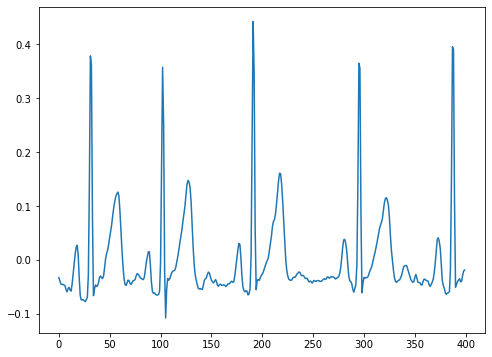

In [12]:
# Setting sampling rate
sampling_rate = 100
print("Sampling rate:", sampling_rate)

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        if i % (sampling_rate/2) == 0: # to reduce redundancy in ECG-data ## maybe even ==sampling_rate to *remove* redundancy?
            # find the end of this pattern
            end_ix = i + n_steps_in
            out_end_ix = end_ix + n_steps_out
            # check if we are beyond the sequence
            if out_end_ix > len(sequence):
                break
            # gather input and output parts of the pattern
            seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
            X.append(seq_x)
            y.append(seq_y)
    return array(X), array(y)

# choose a number of time steps
n_steps_in, n_steps_out = 3*sampling_rate, 1*sampling_rate
# split into samples
'''only for 1 participant so far'''
X, y = split_sequence(data[0], n_steps_in, n_steps_out)
# summarize the data
print(len(data[0]))

# 3D-Data. X = Input, y = output

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
y = y.reshape((y.shape[0], y.shape[1], n_features))
print(X.shape,y.shape)
#plt.plot(y[3,:,0])
print(type(X))
X.dtype

test = np.append(X[3,:,:], y[3,:,:])
plt.plot(test)

In [6]:
# Data split
print(X.shape,y.shape)

num_train_samples = int(0.5 * len(X))
num_val_samples = int(0.25 * len(X))
num_test_samples = len(X) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

X_train = X[:num_train_samples]
y_train = y[:num_train_samples]
X_vali =  X[num_train_samples:(num_train_samples+num_val_samples)]
y_vali = y[num_train_samples:(num_train_samples+num_val_samples)]
X_test = X[(num_train_samples+num_val_samples):]
y_test = y[(num_train_samples+num_val_samples):]

print(len(X_train),len(X_vali),len(X_test))


(593, 300, 1) (593, 100, 1)
num_train_samples: 296
num_val_samples: 148
num_test_samples: 149
296 148 149


In [7]:
# define model
model = Sequential()
model.add(LSTM(300, activation='relu', return_sequences=True, input_shape=(n_steps_in,n_features)))
model.add(LSTM(100, activation='relu'))
#model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse', metrics=["mae"]) # accuracy does not work

In [8]:
# fit model
history = model.fit(X_train, y_train, epochs=64, batch_size=32, verbose=1, validation_data=(X_vali, y_vali))

Epoch 1/64
10/10 [==============================] - 16s 2s/step - loss: 0.0063 - mae: 0.0545 - val_loss: 0.0063 - val_mae: 0.0545
Epoch 2/64
10/10 [==============================] - 16s 2s/step - loss: 0.0062 - mae: 0.0542 - val_loss: 0.0063 - val_mae: 0.0543
Epoch 3/64
10/10 [==============================] - 16s 2s/step - loss: 0.0062 - mae: 0.0538 - val_loss: 0.0062 - val_mae: 0.0540
Epoch 4/64
10/10 [==============================] - 15s 1s/step - loss: 0.0061 - mae: 0.0531 - val_loss: 0.0061 - val_mae: 0.0528
Epoch 5/64
10/10 [==============================] - 15s 2s/step - loss: 0.0059 - mae: 0.0518 - val_loss: 0.0060 - val_mae: 0.0513
Epoch 6/64
10/10 [==============================] - 14s 1s/step - loss: 0.0058 - mae: 0.0505 - val_loss: 0.0058 - val_mae: 0.0502
Epoch 7/64
10/10 [==============================] - 15s 2s/step - loss: 0.0056 - mae: 0.0488 - val_loss: 0.0056 - val_mae: 0.0480
Epoch 8/64
10/10 [==============================] - 15s 1s/step - loss: 0.0054 - mae: 0.04

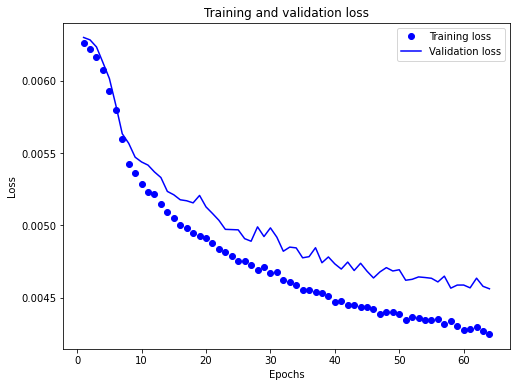

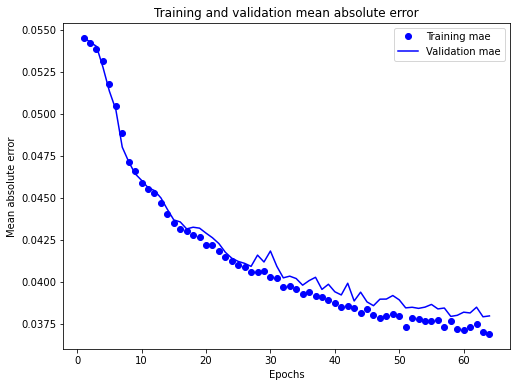

In [9]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.clf()
mae = history_dict["mae"]
val_mae = history_dict["val_mae"]
plt.plot(epochs, mae, "bo", label="Training mae")
plt.plot(epochs, val_mae, "b", label="Validation mae")
plt.title("Training and validation mean absolute error")
plt.xlabel("Epochs")
plt.ylabel("Mean absolute error")
plt.legend()
plt.show()

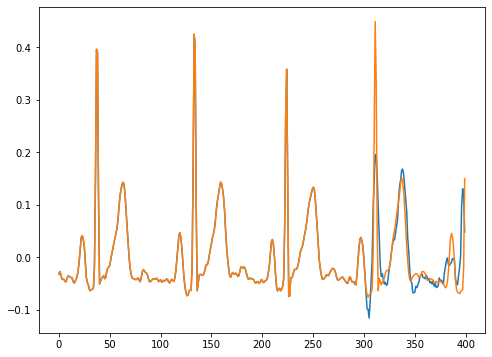

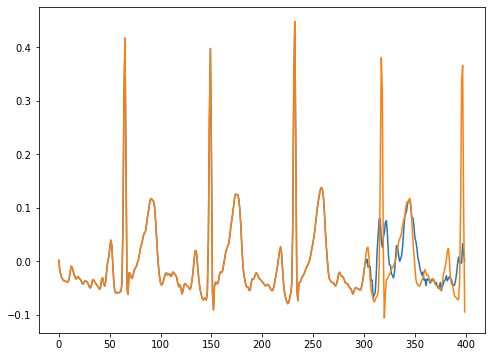

In [14]:
# model demonstration

trial = 10

# demonstrate training
yhat = model.predict(X_train,batch_size=10)

test = np.append(X_train[trial],yhat[trial])
test2 = np.append(X_train[trial],y_train[trial])

plt.figure(1)
plt.plot(test)
plt.plot(test2)

# demonstrate prediction
yhat = model.predict(X_test,batch_size=10)

test = np.append(X_test[trial],yhat[trial])
test2 = np.append(X_test[trial],y_test[trial])

plt.figure(2)
plt.plot(test)
plt.plot(test2)

In [11]:
#tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)